In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.maps as maps

from lsst.sims.utils import hpid2RaDec, galacticFromEquatorial


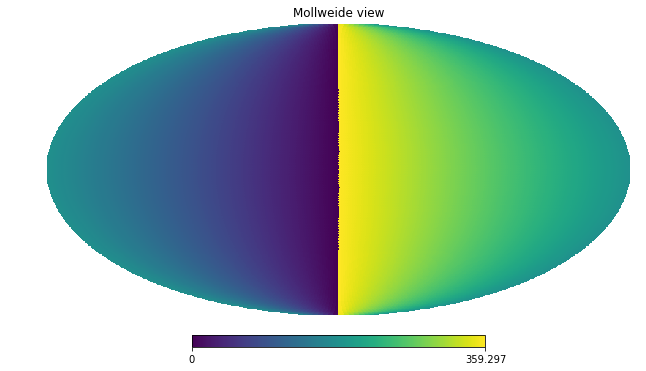

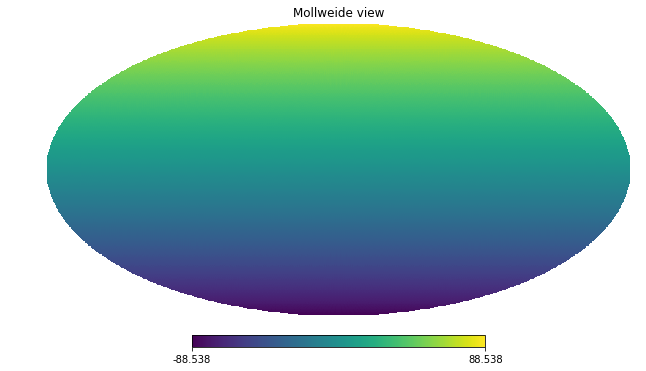

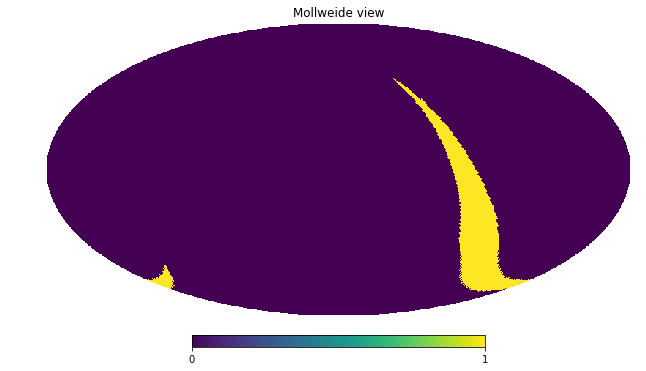

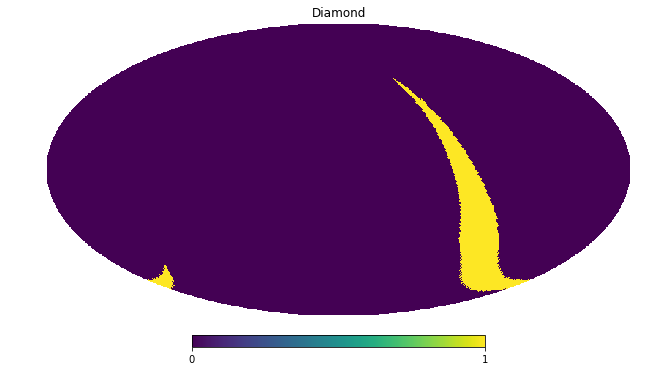

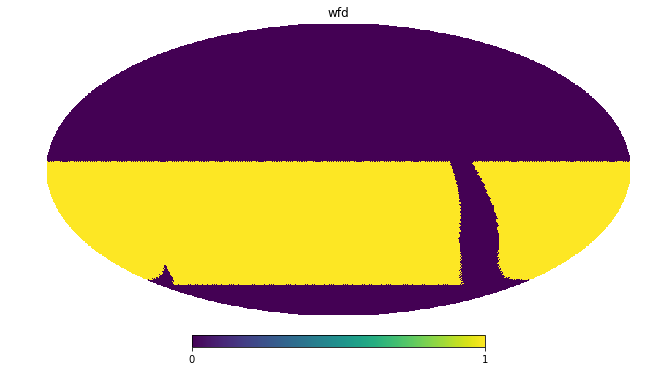

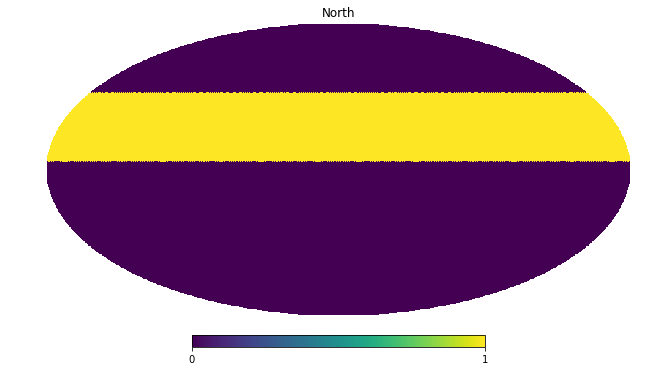

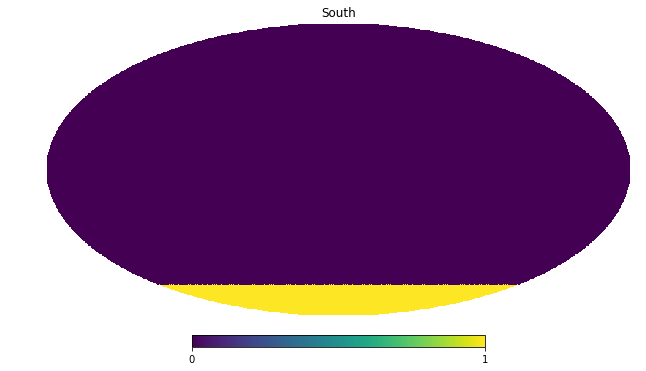

In [2]:
# Set up RA, dec maps
nside = 64
ra, dec = hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
hp.mollview(ra)
hp.mollview(dec)

# Let's define some regions!
g_long, g_lat = galacticFromEquatorial(ra, dec)

#diamond = np.where(((g_long < 90) | (g_long > 270)) & (np.abs(g_lat) < 10))
lat_limit = 10 - 10.*g_long/90.
diamond_map = np.zeros(hp.nside2npix(nside), dtype=float)
for i,g in enumerate(g_long):
    if (g_long[i] < 90) & (np.abs(g_lat[i]) <= lat_limit[i]):
        diamond_map[i] = 1

lat_limit = 10 - 10.*(-g_long+360)/90.
for i,g in enumerate(g_long):
    if (g_long[i] > 270) & (np.abs(g_lat[i]) <= lat_limit[i]):
        diamond_map[i] = 1

hp.mollview(diamond_map)
#diamond_map[diamond] = 1

diamond = np.where(diamond_map == 1)[0]

wfd = np.where((dec > -62.5) & (dec < 3.6))
wfd_map = np.zeros(hp.nside2npix(nside), dtype=float)
wfd_map[wfd] = 1
wfd_map[diamond] = 0
hp.mollview(diamond_map, title='Diamond')
hp.mollview(wfd_map, title='wfd')

north = np.where((dec < 40) & (dec > -20))
north_map = np.zeros(hp.nside2npix(nside), dtype=float)
north_map[north] = 1
north_map[wfd] = 0
hp.mollview(north_map, title='North')

south = np.where(dec < -62)
south_map = np.zeros(hp.nside2npix(nside), dtype=float)
south_map[south] = 1
south_map[wfd] = 0
hp.mollview(south_map, title='South')

regions_dict = {'Diamond': diamond_map, 'North': north_map, 'South': south_map, 'WFD': wfd_map}

In [3]:
dbFile = 'baseline_v1.4_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [4]:
bundleList = []
filtername = 'r'
nside = 64
sql = 'filter="%s"' % filtername
mapsList = [maps.TrilegalDensityMap(filtername=filtername, nside=nside, ext=True)]
metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.1, metricName='Crowding_0.1', maps=[])
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = [metrics.SumMetric()]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats, mapsList=mapsList))

metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.2, metricName='Crowding_0.2', maps=[])
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats, mapsList=mapsList))

metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.2, ignore_crowding=True, metricName='No_Crowding_0.2', maps=[])
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats, mapsList=mapsList))

metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.1, ignore_crowding=True, metricName='No_Crowding_0.1', maps=[])
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats, mapsList=mapsList))

bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'fieldRA']
Found 474955 visits
Running:  ['opsim_Crowding_0_1_r_HEAL', 'opsim_Crowding_0_2_r_HEAL', 'opsim_No_Crowding_0_2_r_HEAL', 'opsim_No_Crowding_0_1_r_HEAL']


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter="r"" constraint now.
monopole: 41681.9  dipole: lon: -139.098, lat: -42.0708, amp: 33906.8
monopole: 89613.8  dipole: lon: -119.299, lat: -34.8892, amp: 107895


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 5470 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 231982  dipole: lon: -99.6901, lat: -22.4542, amp: 394509


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 5498 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 186347  dipole: lon: -99.7549, lat: -22.1645, amp: 315729
Plotting complete.


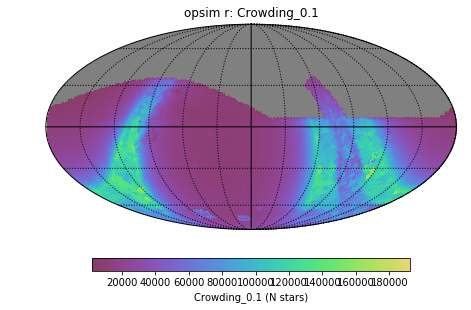

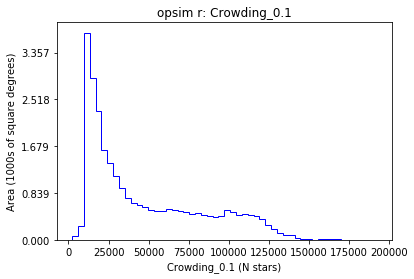

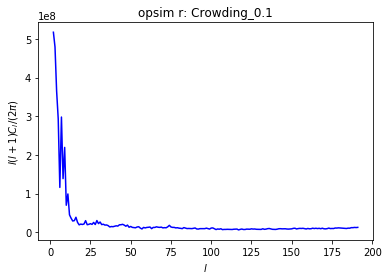

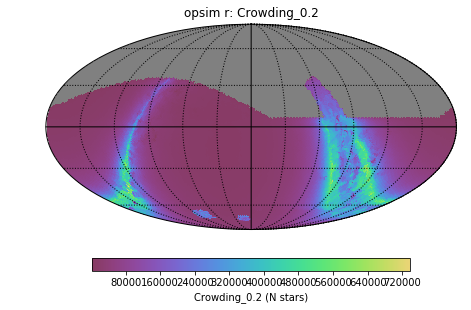

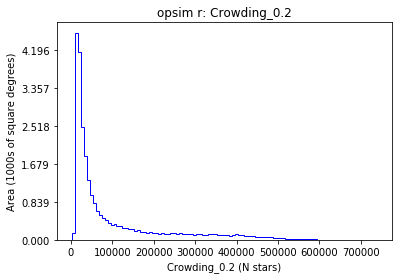

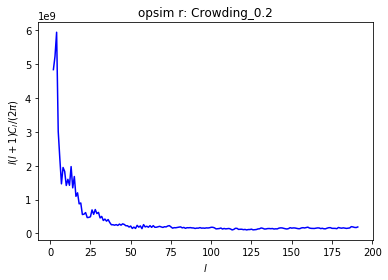

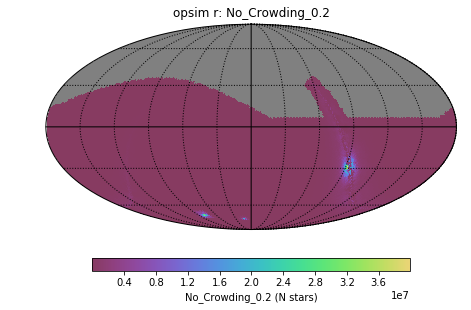

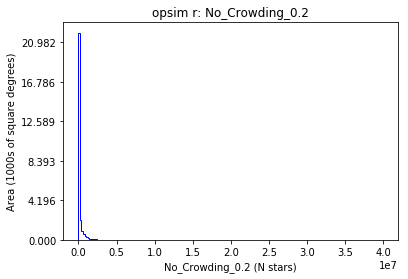

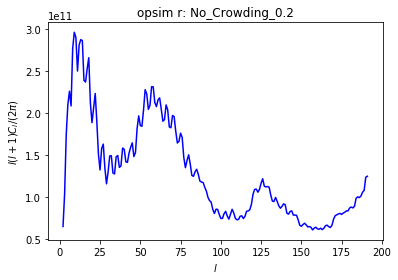

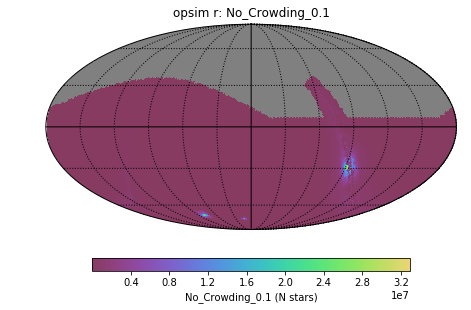

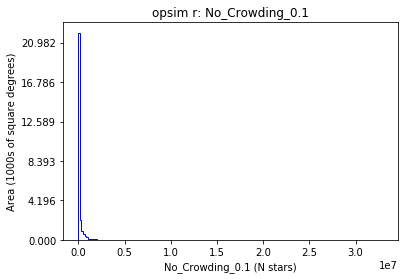

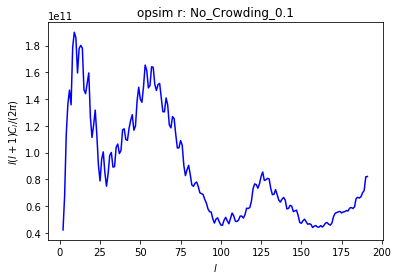

In [5]:
bg.plotAll(closefigs=False)

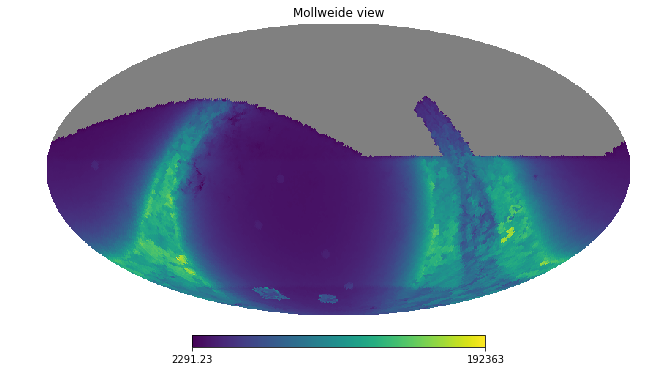

In [6]:
hp.mollview(bundleList[0].metricValues)

In [7]:
for b in bundleList:
    print(b.metric.name, b.summaryValues['Sum']/1e9)

Crowding_0.1 1.5521488462460535
Crowding_0.2 3.3701718773867855
No_Crowding_0.2 8.248664038856772
No_Crowding_0.1 6.606940078232118


In [8]:
print('metric_delta_mag  region  N_stars/1e9')
for b in bundleList:
    for key in regions_dict:
        print(b.metric.name, key,  '%.3f' % (np.sum(b.metricValues*regions_dict[key])/1e9))

metric_delta_mag  region  N_stars/1e9
Crowding_0.1 Diamond 0.144
Crowding_0.1 North 0.176
Crowding_0.1 South 0.137
Crowding_0.1 WFD 1.118
Crowding_0.2 Diamond 0.637
Crowding_0.2 North 0.337
Crowding_0.2 South 0.323
Crowding_0.2 WFD 2.173
No_Crowding_0.2 Diamond 4.551
No_Crowding_0.2 North 0.614
No_Crowding_0.2 South 0.997
No_Crowding_0.2 WFD 2.456
No_Crowding_0.1 Diamond 3.645
No_Crowding_0.1 North 0.486
No_Crowding_0.1 South 0.768
No_Crowding_0.1 WFD 1.998


In [9]:
data = np.load('/Users/yoachim/git_repos/sims_maps/TriMaps/TRIstarDensity_%s_nside_64_ext.npz' % filtername)
# Cumulative number counts, units of stars/sq deg. Array at healpix locations
starDensity = data['starDensity'].copy()
# magnitude bins 
bins=data['bins'].copy()
# pixels where there were so many stars some were skipped
mask = data['overMaxMask']

In [10]:
starDensity.shape, bins.shape

((49152, 65), (66,))

In [11]:
mid_bin = (bins[1:]+bins[0:-1])/2.

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


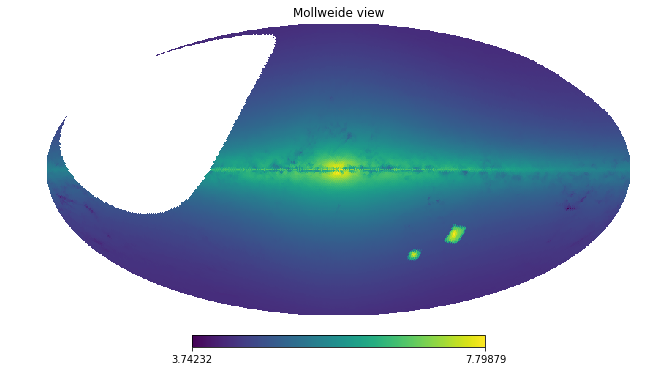

In [12]:
hp.mollview(np.log10(starDensity[:,-1]), nest=True)

In [13]:
area = hp.nside2pixarea(nside, degrees=True)
tot = np.sum(starDensity[:,-1])*area

In [14]:
tot/1e9

12.000009143

(24, 28)

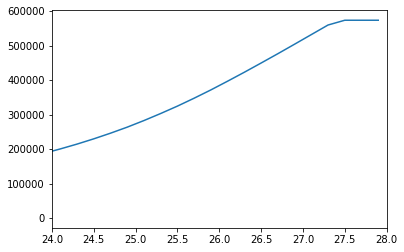

In [15]:
plt.plot(mid_bin, starDensity[100, :])
plt.xlim([24,28])